In [1]:
# ==================================
#  0. 必要ライブラリのインポート
# ==================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Seabornのスタイル設定
sns.set_style('whitegrid')

# 乱数シードの固定
np.random.seed(42)

In [2]:
# --- 真のパラメータ ---
N = 300
p = 3
alpha_true = 2.0
theta_true = 1.0
beta_true  = np.array([0.5, -0.3, 0.8])
tau0_true  = 1.2
tau1_true  = np.array([0.5, -0.2, 0.3])  # 効果異質性 (p=3)
sigma_true = 1.0
sigma_gamma_true = 0.7

# --- 共変量生成 X_i (N x p) ---
X = np.random.normal(0, 1.0, size=(N,p))

# --- 処置割り当て (logit) ---
#  logit_p = w^T X_i で確率を決定
w_logit = np.array([0.4, -0.1, 0.3])
logit_p = X @ w_logit
prob_d  = 1.0/(1.0 + np.exp(-logit_p))
D = (np.random.rand(N) < prob_d).astype(int)

# --- 個体ランダム効果 gamma_i ---
gamma_i = np.random.normal(0, sigma_gamma_true, size=N)

# --- アウトカム生成 (Y_{i0}, Y_{i1}) ---
#    Y0_i = alpha + gamma_i + X_i^T beta +  eps0
#    Y1_i = alpha + gamma_i + theta + X_i^T beta + (tau0 + X_i^T tau1)*D_i + eps1
Y0 = np.zeros(N)
Y1 = np.zeros(N)

for i in range(N):
    # 効果異質性
    tau_i = tau0_true + X[i,:] @ tau1_true
    
    # Y0
    Y0[i] = alpha_true + gamma_i[i] + (X[i,:] @ beta_true) + np.random.normal(0, sigma_true, 1)
    # Y1
    Y1[i] = alpha_true + gamma_i[i] + theta_true + (X[i,:] @ beta_true) + tau_i * D[i] + np.random.normal(0, sigma_true, 1)

data = {
    'X': X,   # shape (N,p)
    'D': D,   # shape (N,)
    'Y0': Y0, # shape (N,)
    'Y1': Y1  # shape (N,)
}


/var/folders/g2/s8vwylzn1gn5mf9xlm143dm80000gn/T/ipykernel_11327/588150082.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y0[i] = alpha_true + gamma_i[i] + (X[i,:] @ beta_true) + np.random.normal(0, sigma_true, 1)
/var/folders/g2/s8vwylzn1gn5mf9xlm143dm80000gn/T/ipykernel_11327/588150082.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y1[i] = alpha_true + gamma_i[i] + theta_true + (X[i,:] @ beta_true) + tau_i * D[i] + np.random.normal(0, sigma_true, 1)


In [3]:
def gibbs_did_cate_p3(data, n_iter=5000, burn_in=1000):
    """
    Gibbsサンプリング: 効果異質性 (tau0 + tau1^T X) & random intercept付きDiD。
    
    data: dict with { 'X':(N,p), 'D':(N,), 'Y0':(N,), 'Y1':(N,) }
    モデル:
      Y0_i = alpha + gamma_i + X_i^T beta + eps0
      Y1_i = alpha + gamma_i + theta + X_i^T beta + (tau0 + X_i^T tau1)*D_i + eps1
      gamma_i ~ Normal(0, sigma_gamma^2), eps ~ Normal(0, sigma^2)
    事前:
      alpha, theta, beta[j], tau0, tau1[j] ~ Normal(0, sigma0_sq)
      sigma^2, sigma_gamma^2 ~ InvGamma(a0, b0)
    """
    X = data['X']
    D = data['D']
    Y0= data['Y0']
    Y1= data['Y1']
    N, p = X.shape
    
    # ハイパーパラメータ
    sigma0_sq = 100.0
    a0 = 2.0
    b0 = 2.0
    
    # 初期値
    alpha = 0.0
    theta = 0.0
    beta  = np.zeros(p)
    tau0  = 0.0
    tau1  = np.zeros(p)
    gamma_i = np.zeros(N)
    sigma2 = 1.0
    sigma2_gamma = 1.0
    
    # 結果格納用
    chain = {
        'alpha': [],
        'theta': [],
        'beta': [],
        'tau0': [],
        'tau1': [],
        'gamma': [],
        'sigma2': [],
        'sigma2_gamma': []
    }
    
    def rinvgamma(shape, rate):
        return 1.0 / np.random.gamma(shape, 1.0/rate)
    
    for it in range(n_iter):
        # (1) gamma_i の更新
        for i in range(N):
            # 残差
            r0 = Y0[i] - (alpha + X[i,:]@beta)
            r1 = Y1[i] - (alpha + theta + X[i,:]@beta + (tau0 + X[i,:]@tau1)*D[i])
            prec = 2.0/sigma2 + 1.0/sigma2_gamma
            var_i = 1.0 / prec
            mu_i  = (r0 + r1)/sigma2 * var_i
            gamma_i[i] = np.random.normal(mu_i, np.sqrt(var_i))
        
        # (2) (alpha,theta,beta,tau0,tau1) の更新 (block)
        dim_w = 2 + p + 1 + p  # = 2p + 3
        Z = np.zeros((2*N, dim_w))
        y = np.zeros(2*N)
        
        # w = [alpha, theta, beta(1..p), tau0, tau1(1..p)]
        for i in range(N):
            # Y0
            y[2*i] = Y0[i] - gamma_i[i]
            Z[2*i, 0] = 1.0  # alpha
            Z[2*i, 1] = 0.0  # theta
            Z[2*i, 2:2+p] = X[i,:]   # beta
            Z[2*i, 2+p]   = 0.0      # tau0
            Z[2*i, (2+p+1):(2+p+1+p)] = 0.0  # tau1
            
            # Y1
            y[2*i+1] = Y1[i] - gamma_i[i]
            Z[2*i+1, 0] = 1.0
            Z[2*i+1, 1] = 1.0
            Z[2*i+1, 2:2+p] = X[i,:]
            Z[2*i+1, 2+p]   = D[i]  # tau0
            Z[2*i+1, (2+p+1):(2+p+1+p)] = X[i,:]*D[i]  # tau1 * X_i * D_i
        
        prec_prior = (1.0/sigma0_sq)*np.eye(dim_w)
        prec_lik   = (Z.T @ Z)/sigma2
        V_inv      = prec_prior + prec_lik
        V          = np.linalg.inv(V_inv)
        
        mean_part  = (Z.T @ y)/sigma2
        w_hat      = V @ mean_part
        
        w_sample   = np.random.multivariate_normal(w_hat, V)
        
        alpha = w_sample[0]
        theta = w_sample[1]
        beta  = w_sample[2:2+p]
        tau0  = w_sample[2+p]
        tau1  = w_sample[(2+p+1):(2+p+1+p)]
        
        # (3) sigma^2 の更新
        rss = 0.0
        for i in range(N):
            r0 = Y0[i] - (alpha + gamma_i[i] + X[i,:]@beta)
            r1 = Y1[i] - (alpha + gamma_i[i] + theta + X[i,:]@beta 
                          + (tau0 + X[i,:]@tau1)*D[i])
            rss += r0**2 + r1**2
        shape_post = a0 + (2*N)/2
        rate_post  = b0 + 0.5*rss
        sigma2     = rinvgamma(shape_post, rate_post)
        
        # (4) sigma_gamma^2 の更新
        g_sumsq = np.sum(gamma_i**2)
        shape_g = a0 + N/2
        rate_g  = b0 + 0.5*g_sumsq
        sigma2_gamma = rinvgamma(shape_g, rate_g)
        
        # チェーン格納
        chain['alpha'].append(alpha)
        chain['theta'].append(theta)
        chain['beta'].append(beta.copy())
        chain['tau0'].append(tau0)
        chain['tau1'].append(tau1.copy())
        chain['gamma'].append(gamma_i.copy())
        chain['sigma2'].append(sigma2)
        chain['sigma2_gamma'].append(sigma2_gamma)
    
    # burn-in 後のサンプルを返す
    chain_out = {}
    for k,v in chain.items():
        chain_out[k] = np.array(v)[burn_in:]
    return chain_out

# --- 実行 ---
posterior = gibbs_did_cate_p3(data, n_iter=6000, burn_in=2000)


In [4]:
def plot_posterior_distributions(posterior):
    """
    posterior: dict
      {
        'alpha': (n_samp,),
        'theta': (n_samp,),
        'beta': (n_samp, p),
        'tau0': (n_samp,),
        'tau1': (n_samp, p),
        'gamma': (n_samp, N),
        'sigma2': (n_samp,),
        'sigma2_gamma': (n_samp,)
      }
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    sns.set_style('whitegrid')
    
    # alpha
    fig, axes = plt.subplots(3, 2, figsize=(12,12))
    # alpha trace
    axes[0,0].plot(posterior['alpha'], color='blue', alpha=0.5)
    axes[0,0].set_title("Trace: alpha")
    # alpha hist
    sns.histplot(posterior['alpha'], kde=True, ax=axes[0,1], color='blue')
    axes[0,1].set_title("Posterior dist: alpha")
    
    # theta trace
    axes[1,0].plot(posterior['theta'], color='red', alpha=0.5)
    axes[1,0].set_title("Trace: theta")
    # theta hist
    sns.histplot(posterior['theta'], kde=True, ax=axes[1,1], color='red')
    axes[1,1].set_title("Posterior dist: theta")
    
    # sigma2 trace
    axes[2,0].plot(posterior['sigma2'], color='green', alpha=0.5)
    axes[2,0].set_title("Trace: sigma^2")
    # sigma2 hist
    sns.histplot(posterior['sigma2'], kde=True, ax=axes[2,1], color='green')
    axes[2,1].set_title("Posterior dist: sigma^2")
    
    plt.tight_layout()
    plt.show()
    
    # --- beta, tau0, tau1 などを別枠で可視化 ---
    fig, axes = plt.subplots(p+1, 2, figsize=(10, 5*(p+1)))
    for j in range(p):
        # beta_j
        param_chain = posterior['beta'][:, j]
        axes[j,0].plot(param_chain, alpha=0.5)
        axes[j,0].set_title(f"Trace: beta[{j}]")
        sns.histplot(param_chain, kde=True, ax=axes[j,1])
        axes[j,1].set_title(f"Posterior dist: beta[{j}]")
    
    # tau0
    row_last = p
    param_t0 = posterior['tau0']
    axes[row_last,0].plot(param_t0, alpha=0.5, color='darkorange')
    axes[row_last,0].set_title("Trace: tau0")
    sns.histplot(param_t0, kde=True, ax=axes[row_last,1], color='darkorange')
    axes[row_last,1].set_title("Posterior dist: tau0")
    
    plt.tight_layout()
    plt.show()
    
    # --- tau1: p次元 ---
    fig, axes = plt.subplots(p, 2, figsize=(10, 4*p))
    for j in range(p):
        param_t1j = posterior['tau1'][:, j]
        axes[j,0].plot(param_t1j, alpha=0.5)
        axes[j,0].set_title(f"Trace: tau1[{j}]")
        sns.histplot(param_t1j, kde=True, ax=axes[j,1])
        axes[j,1].set_title(f"Posterior dist: tau1[{j}]")
    plt.tight_layout()
    plt.show()
    
    # --- sigma^2_gamma ---
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].plot(posterior['sigma2_gamma'], alpha=0.5, color='purple')
    axes[0].set_title("Trace: sigma^2_gamma")
    sns.histplot(posterior['sigma2_gamma'], kde=True, ax=axes[1], color='purple')
    axes[1].set_title("Posterior dist: sigma^2_gamma")
    plt.tight_layout()
    plt.show()


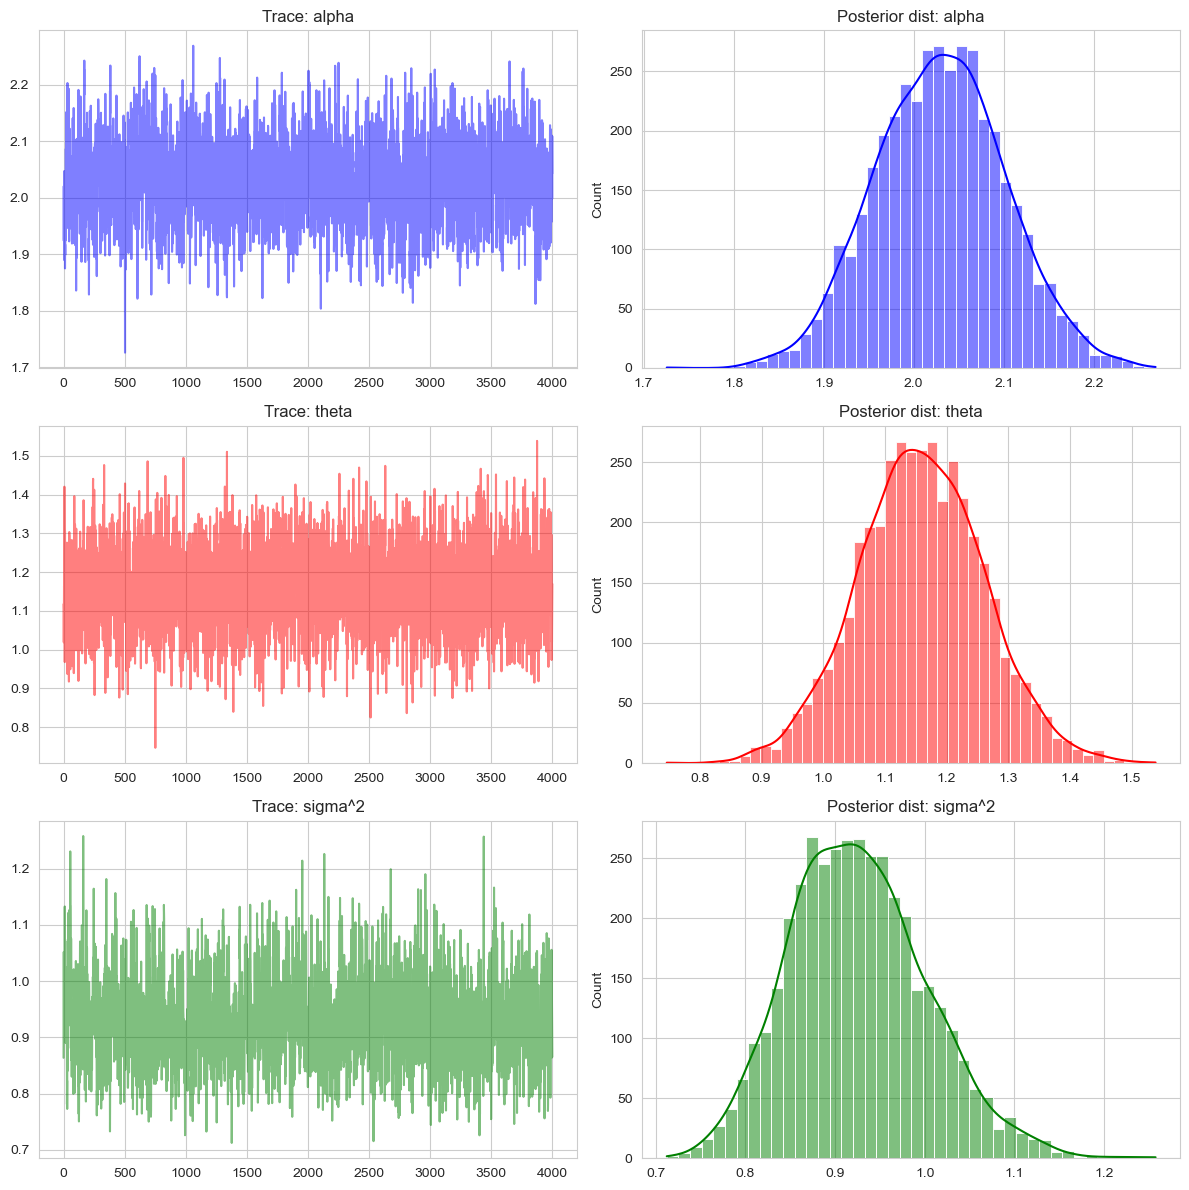

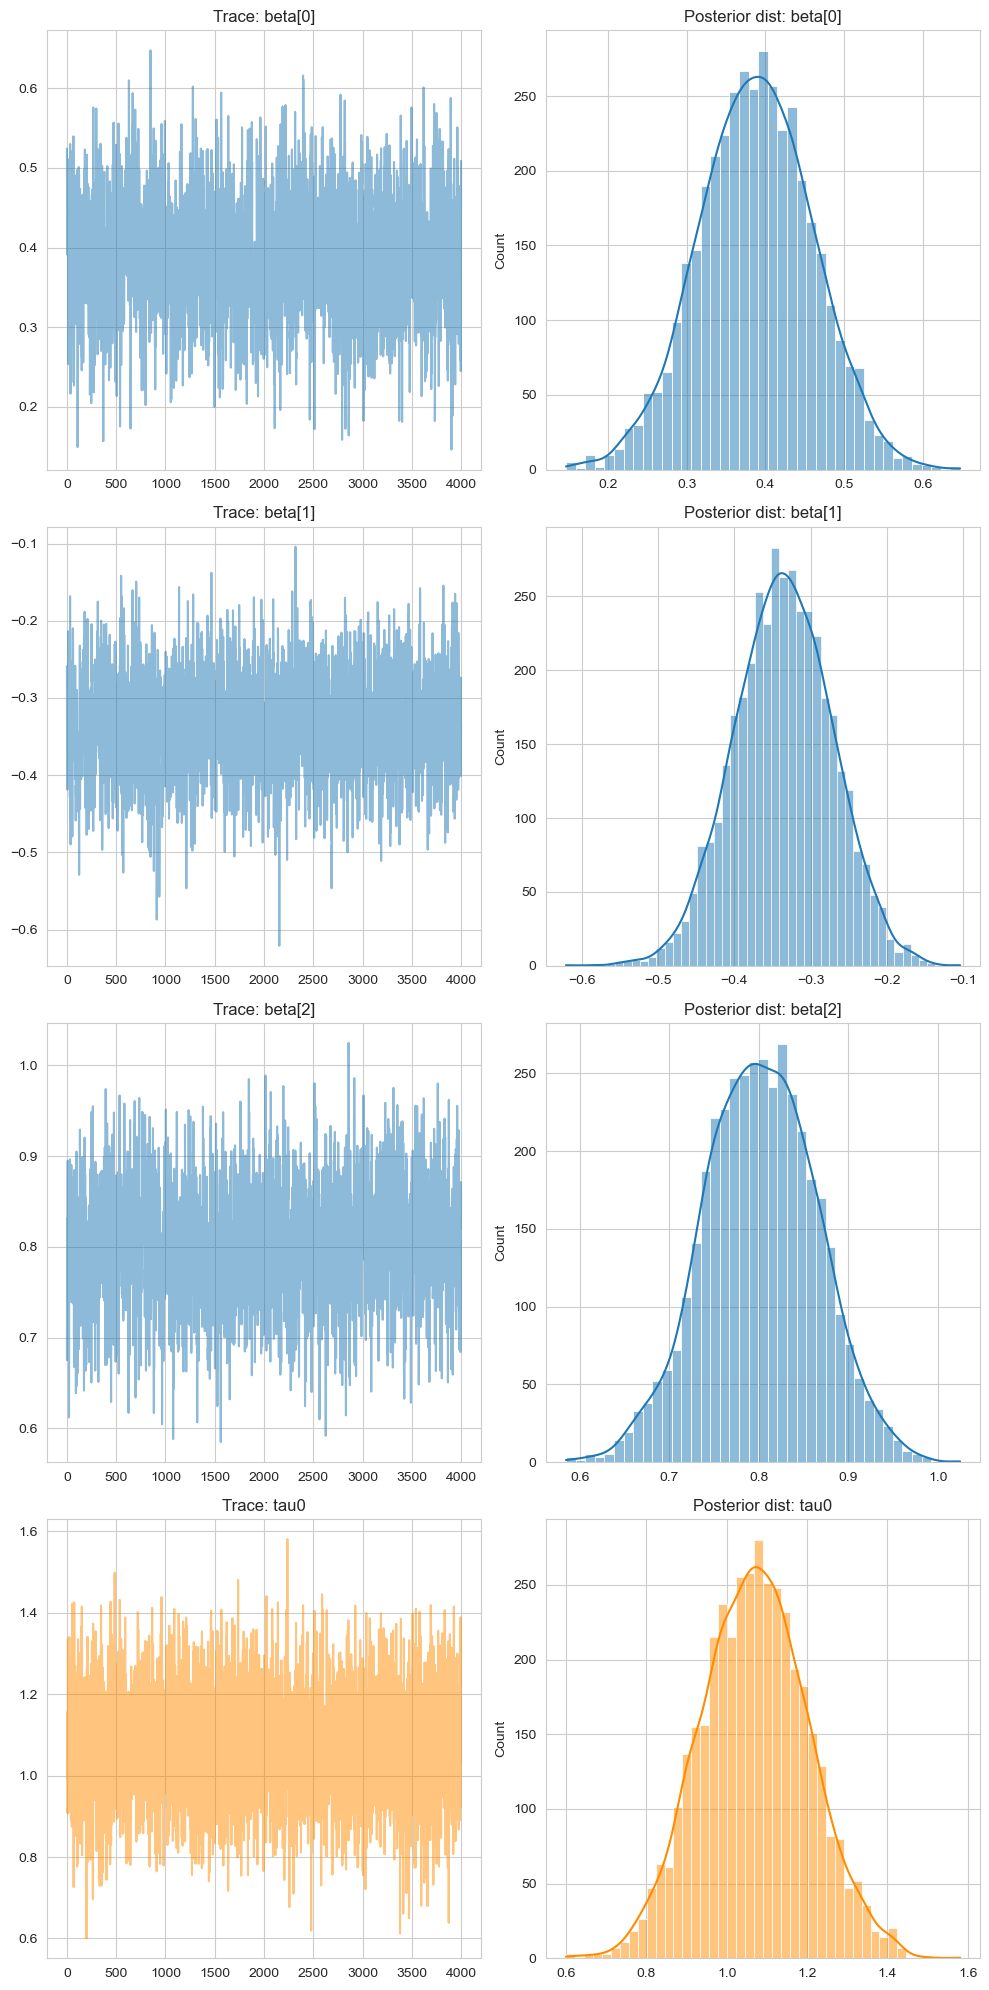

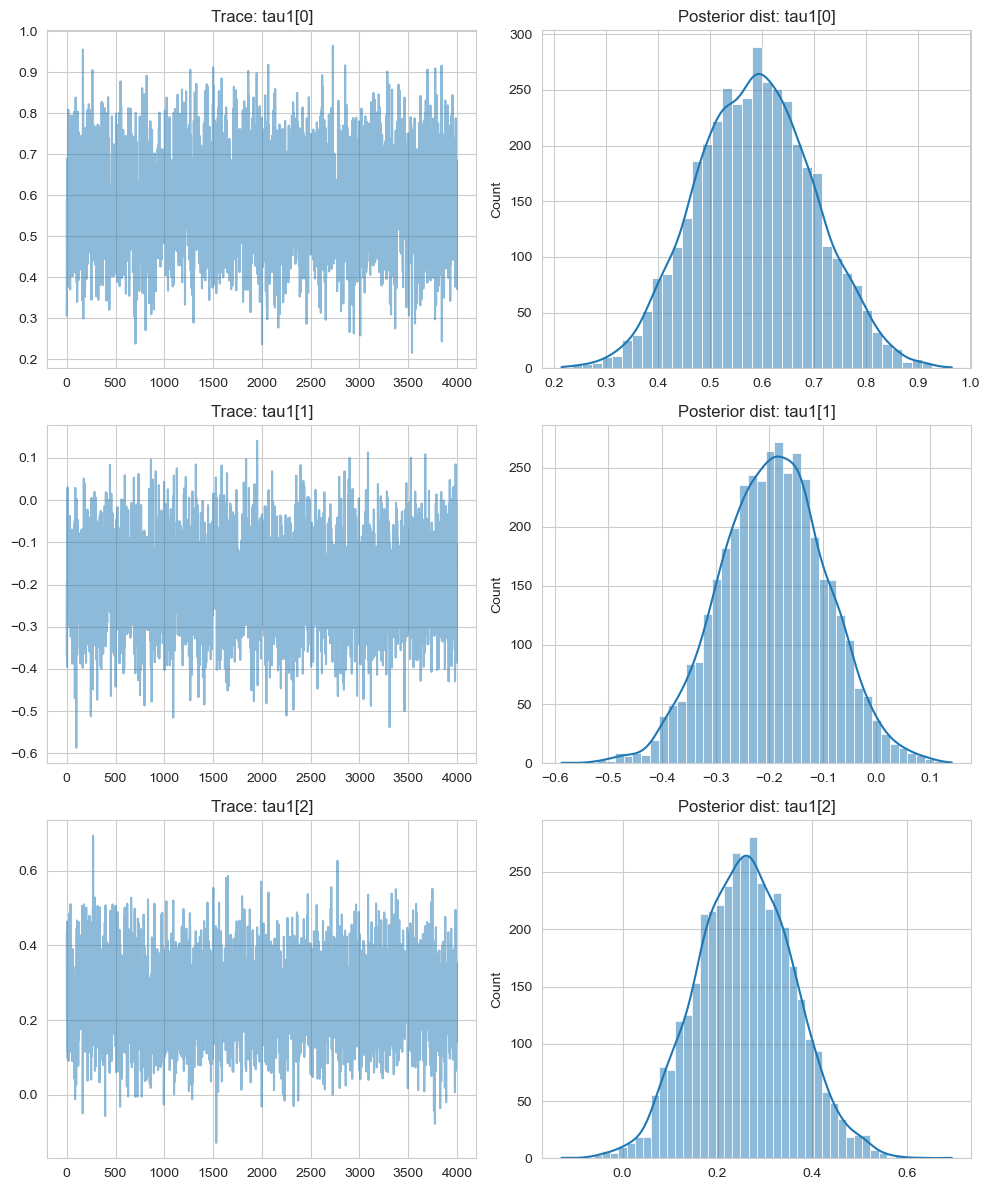

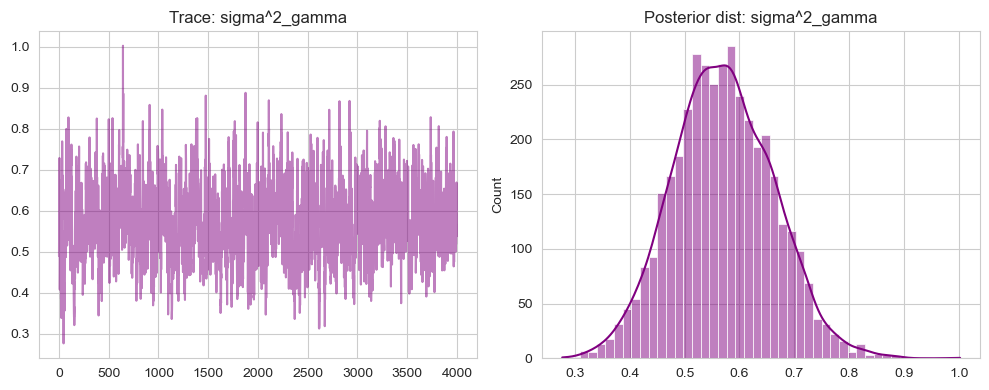

In [5]:
plot_posterior_distributions(posterior)

In [6]:
# 事後平均を取得
alpha_post = posterior['alpha'].mean()
theta_post = posterior['theta'].mean()
beta_post  = posterior['beta'].mean(axis=0)
tau0_post  = posterior['tau0'].mean()
tau1_post  = posterior['tau1'].mean(axis=0)

print(f"Posterior mean of alpha : {alpha_post:.3f} (true={alpha_true})")
print(f"Posterior mean of theta : {theta_post:.3f} (true={theta_true})")
print(f"Posterior mean of beta  : {beta_post} (true={beta_true})")
print(f"Posterior mean of tau0  : {tau0_post:.3f} (true={tau0_true})")
print(f"Posterior mean of tau1  : {tau1_post} (true={tau1_true})")


Posterior mean of alpha : 2.029 (true=2.0)
Posterior mean of theta : 1.158 (true=1.0)
Posterior mean of beta  : [ 0.38794027 -0.33605436  0.80173926] (true=[ 0.5 -0.3  0.8])
Posterior mean of tau0  : 1.070 (true=1.2)
Posterior mean of tau1  : [ 0.58747702 -0.19254712  0.25832796] (true=[ 0.5 -0.2  0.3])


In [7]:
tau0_samps = posterior['tau0']      # shape (n_post,)
tau1_samps = posterior['tau1']      # shape (n_post, p)

# テスト用に x の候補をいくつか用意
x_candidates = [
    np.array([-1, -1, -1]),
    np.array([-1,  0,  1]),
    np.array([ 0,  0,  0]),
    np.array([ 1,  0, -1]),
    np.array([-1.0, 1.0,  1.5]),
    np.array([ 1,  1,  1])
]

for x_val in x_candidates:
    # 各サンプル s で tau(s) = tau0_samps[s] + x_val^T tau1_samps[s,:]
    tau_x = tau0_samps + np.sum(tau1_samps * x_val, axis=1)
    m = np.mean(tau_x)
    ci_lower = np.percentile(tau_x, 2.5)
    ci_upper = np.percentile(tau_x, 97.5)
    print(f"x={x_val} => CATE mean={m:.3f}, 95%CI=({ci_lower:.3f}, {ci_upper:.3f})")



x=[-1 -1 -1] => CATE mean=0.416, 95%CI=(-0.059, 0.880)
x=[-1  0  1] => CATE mean=0.741, 95%CI=(0.359, 1.131)
x=[0 0 0] => CATE mean=1.070, 95%CI=(0.808, 1.335)
x=[ 1  0 -1] => CATE mean=1.399, 95%CI=(1.014, 1.794)
x=[-1.   1.   1.5] => CATE mean=0.677, 95%CI=(0.196, 1.149)
x=[1 1 1] => CATE mean=1.723, 95%CI=(1.315, 2.131)
